<a href="https://colab.research.google.com/github/JR-1991/sysbiojax/blob/master/TestBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/JR-1991/sysbiojax.git

In [3]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax.random import PRNGKey
from numpyro.infer import MCMC, NUTS

from sysbiojax import Model

az.style.use("arviz-doc")

numpyro.enable_x64(True)

In [4]:
# Initialize the model
model = Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Add parameter values
model.parameters.v_max.value = 5.0
model.parameters.K_m.value = 100.0

model

Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[K_m, v_max]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

In [6]:
# Generate irregular time series data generated
# from a simple menten model

time = jnp.array([
    [0, 10, 20 , 30 ,40 ,50 ,60 ,70 ,80 ,90 ,100],
    [15, 25 , 35 ,45 ,55 ,62 ,78 ,82 ,98 ,100, 108],
    [11, 12, 23 , 35 ,41 ,52 ,68 ,75 ,86 ,96 ,110],
    [23 , 35 ,41 ,52 ,68 ,75 ,86 ,96 ,110, 122, 130],
])

initial_conditions = [
    {"s1": 300.0},
    {"s1": 200.0},
    {"s1": 100.0},
    {"s1": 50.0},
    
]

# Km and vmax
params = jnp.array([100.0, 7.0])

time, data = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1, saveat=time,
    parameters=params, in_axes=(0, None, 0)
)

time = jnp.squeeze(time)
data = jnp.squeeze(data)

# Add some noise for realism
noisify = lambda x: x + np.random.normal(0, 0.03, size=x.shape[0])*x
data = np.array([noisify(data[i, :]) for i in range(data.shape[0])])

time.shape, data.shape

((4, 11), (4, 11))

<ipython-input-7-4d479f466a13>:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


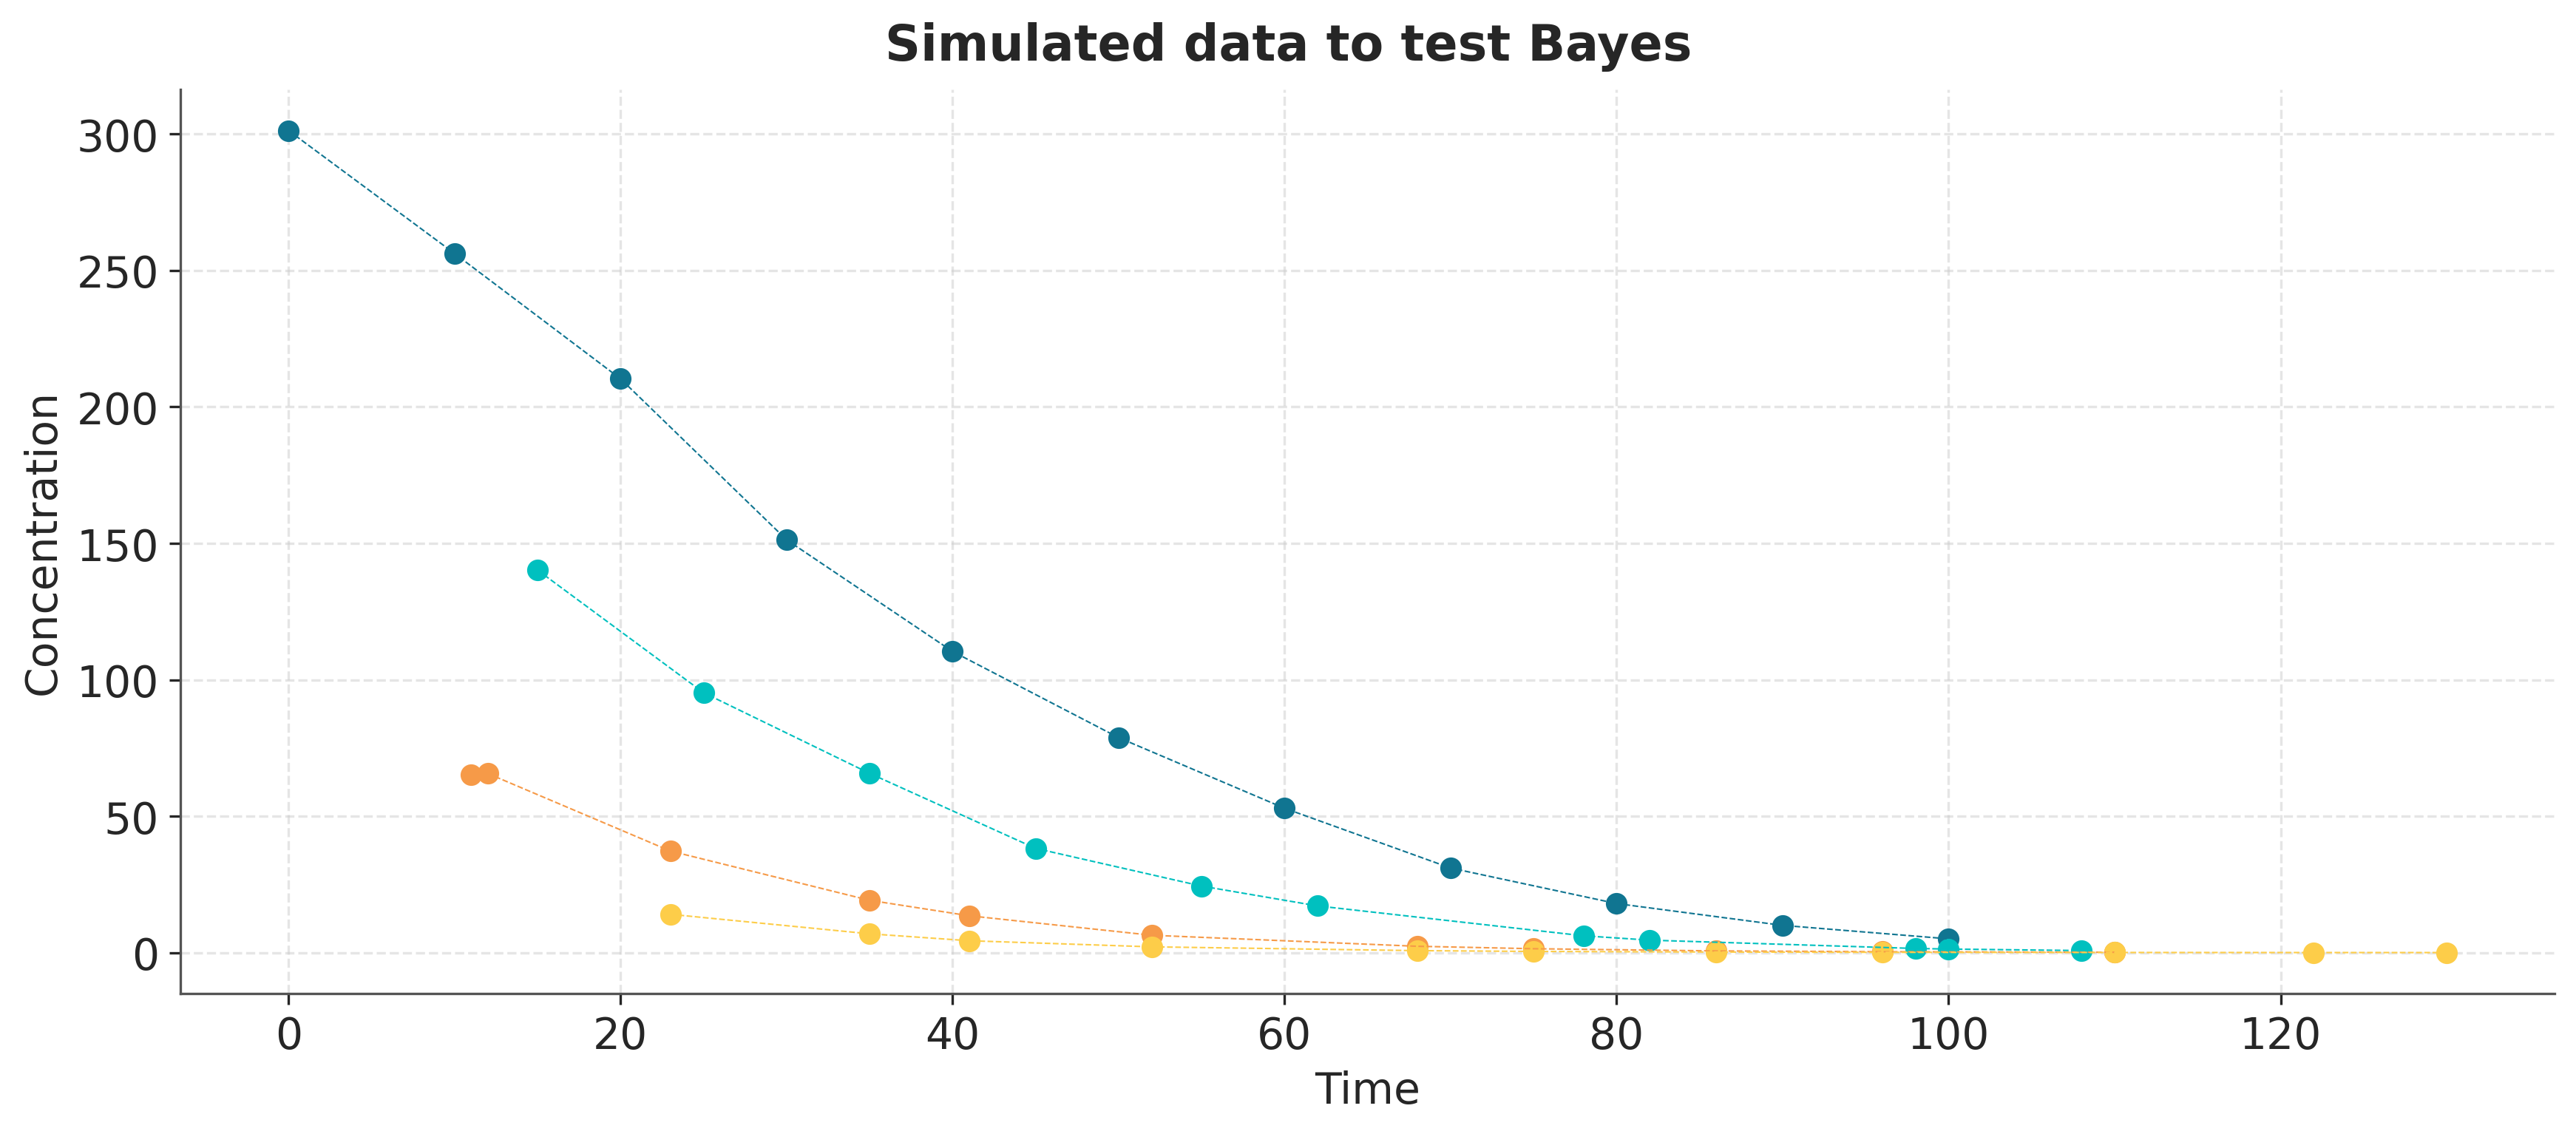

In [7]:
# Visualize generated data
for init in range(0, data.shape[0]):
    plt.scatter(time[init, :], data[init, :])
    plt.plot(time[init, :], data[init, :], linestyle="--", linewidth=.5)
    
    
plt.grid(alpha=0.5, linestyle="--")

plt.xlabel("Time")
plt.ylabel("Concentration")

plt.suptitle("Simulated data to test Bayes", fontsize=16)
plt.tight_layout()

In [8]:
# Setup the bayes model
# For now, priors are hard-coded, but in the future
# there will be a way to specify them in the model

def bayes_model(data, y0s, times, initial_guesses, sim_func):
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=jnp.array([1.0, 0.01]),
            high=jnp.array([180.0, 100.0]),
            loc=initial_guesses,
            scale=jnp.array([0.01, 0.01]),
        ),
    )

    _, states = sim_func(y0s, theta, times)
    sigma = numpyro.sample("sigma", dist.Normal(0, 0.01))
    
    numpyro.sample("y", dist.Normal(jnp.squeeze(states), sigma), obs=data)

In [9]:
# use dense_mass for better mixing rate
mcmc = MCMC(
    NUTS(bayes_model, dense_mass=True),
    num_warmup=500,
    num_samples=500,
    progress_bar=True,
)

# Assemble the initial conditions into an array
y0s = model._assemble_y0_array(initial_conditions, in_axes=(0, None, 0))

mcmc.run(
    PRNGKey(20),
    data=data,
    sim_func=model._sim_func,
    y0s=y0s,
    times=time,
    initial_guesses=params,
)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [01:54<00:00,  8.75it/s, 31 steps of size 4.61e-02. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.40      0.01      0.40      0.39      0.41     83.49      1.08
  theta[0]    100.00      0.01    100.00     99.98    100.01    531.41      1.00
  theta[1]      7.02      0.01      7.02      7.01      7.03    276.15      1.00

Number of divergences: 0


Text(0.5, 1.0, '$v_{max}$')

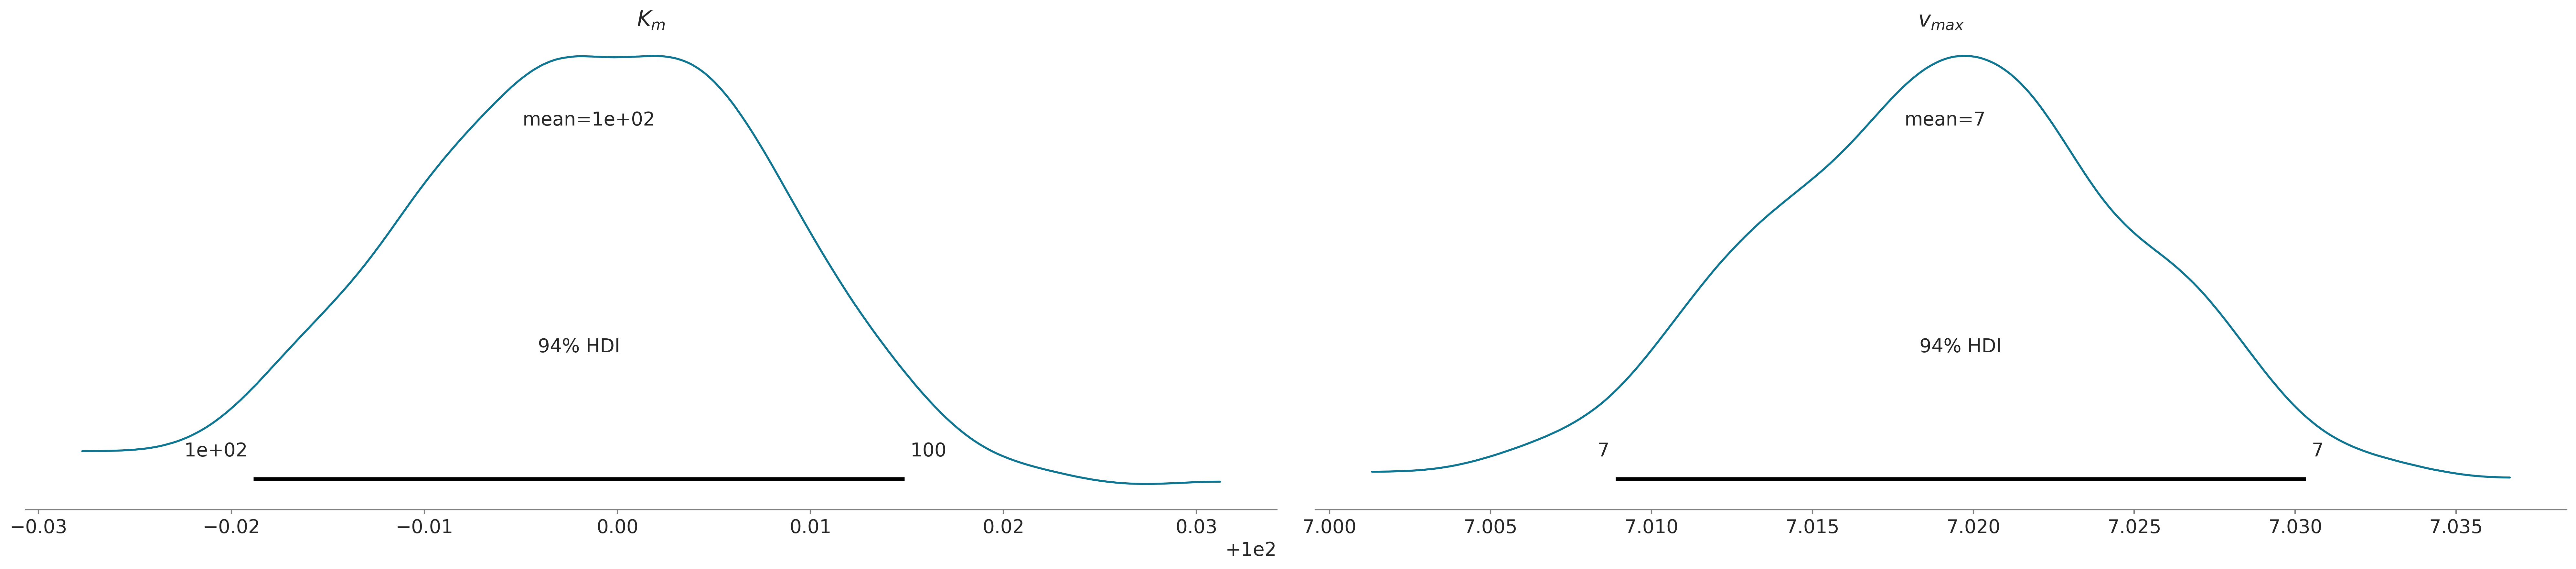

In [10]:
# Plot posteriors (Theta0 := Km, Theta1 := Vmax)
inf_data = az.from_numpyro(mcmc)
ax = az.plot_posterior(inf_data, var_names=["theta"])
ax[0].set_title("$K_m$")
ax[1].set_title("$v_{max}$")